In [1]:
import random
import csv
import os
import pickle
import sys
import pandas as pd
os.chdir('Resources/')

In [2]:
def power(b, p, m):
    b = b % m
    if p == 0:
        return 1
    j = power(b, p // 2, m)
    j = (j * j) % m
    if p % 2 == 1:
        j = (j * b) % m
    return j

In [3]:
def split_message(message, max_size):
    encoded = message.encode()
    chunks = [encoded[i:i + max_size] for i in range(0, len(encoded), max_size)]
    return [int.from_bytes(chunk, 'big') for chunk in chunks]

In [4]:
def join_chunks(chunks, max_size):
    """Reassemble integer chunks into the original message."""
    message_bytes = b''.join(chunk.to_bytes(max_size, 'big') for chunk in chunks)
    return message_bytes.decode(errors='ignore')

In [5]:
def verify_signature(signed_chunks, original_message, public_key):
    """Verify the RSA signature by decrypting and comparing."""
    e, n = public_key
    max_bytes = (n.bit_length() // 8) - 1

    original_chunks = split_message(original_message, max_bytes)

    decrypted_chunks = [power(sig, e, n) for sig in signed_chunks]

    return original_chunks == decrypted_chunks

In [6]:
def load_key(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [7]:
su_rsa_1_public_key = load_key("17_SU_RSA_1_Public_Key.pkl")
su_rsa_1_public_key

(800039276376817193, 12056529777636162823)

In [8]:
with open("23_(SYS)_CC_Transmitted_User_Output_Data.csv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    rows = list(reader)

encrypted_aes_key = rows[0][0]
encrypted_data = rows[1][0]
signed_chunks = eval(rows[2][0])

print(encrypted_aes_key, '\n', encrypted_data, '\n', signed_chunks)

1401078831196967303 
 [F[\D^SFRYD_[F\DR\FYD_F[[DX[F]D^\F^D^RFYDYYF\D\XFYDR[FYD^RF]DSRFX^D]S 
 [10157239781934559752, 10062977358364607205, 5568479385692153325, 9093427784715901898, 9594345489230289981, 1307713079321390238, 7727664801510162456, 2923087285957354114, 9076400092781076890, 5014189973543546288, 8774351438908640735, 2597567152988309471, 8637281600472874339]


In [9]:
original_message = str(encrypted_aes_key) + '\n' + encrypted_data
is_valid = verify_signature(signed_chunks, original_message, su_rsa_1_public_key)

print("Signature Verification:", "Valid" if is_valid else "Invalid")

Signature Verification: Valid


In [10]:
su_rsa_2_private_key = load_key("16_SU_RSA_2_Private_Key.pkl")
su_rsa_2_private_key

(4642646676108725137, 4774294288111246121)

In [11]:
def decrypt_data_with_aes(encrypted_data, key):
    decrypted_data = "".join(chr(ord(c) ^ key) for c in encrypted_data)
    return decrypted_data

In [12]:
def decrypt_aes_key_with_rsa(encrypted_aes_key, private_key):
    d, n = private_key
    return power(encrypted_aes_key, d, n)

In [13]:
import csv

def decrypt_and_map_csv(input_filename, private_key, output_filename):
    with open(input_filename, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        rows = list(reader)

    encrypted_aes_key = int(rows[0][0])  
    encrypted_data = rows[1][0]  

    aes_key = decrypt_aes_key_with_rsa(encrypted_aes_key, private_key)
    decrypted_data = decrypt_data_with_aes(encrypted_data, aes_key)

    column_names = [
        "Age", "Sex", "ChestPainType", "RestingBloodPressure", "Cholesterol",
        "FastingBloodSugar", "RestingECG", "MaximumHeartRate", "ExerciseAngina",
        "Oldpeak", "ST_Slope", "HeartDisease"
    ]

    decrypted_values = decrypted_data.split(",")
    prediction = "Yes" if int(decrypted_values[0]) == 1 else "No"
    prob_no = float(decrypted_values[1])
    prob_yes = float(decrypted_values[2])
    feature_contributions = [(i - 3, column_names[i - 3], float(decrypted_values[i])) for i in range(3, len(decrypted_values))]
    
    feature_contributions.sort(key=lambda x: x[2], reverse=True)
    
    user_data = pd.read_csv("18_(SYS)_SU_User_Data.csv", header=None)
    user_values = user_data.iloc[0].tolist() 

    mappings = {
        0: {0: 'Young', 1: 'Middle-aged', 2: 'Senior', 3: 'Elderly'},
        1: {0: 'Female', 1: 'Male'},
        2: {0: 'Typical Angina', 1: 'Atypical Angina', 2: 'Non-anginal Pain', 3: 'Asymptomatic'},
        3: {0: 'Low', 1: 'Normal', 2: 'Pre-high', 3: 'High'},
        4: {0: 'Desirable', 1: 'Borderline High', 2: 'High'},
        5: {0: 'No', 1: 'Yes'},
        6: {0: 'Normal', 1: 'Abnormal ST-T Wave', 2: 'Left Ventricular Hypertrophy'},
        7: {0: 'Low', 1: 'Moderate', 2: 'High'},
        8: {0: 'No', 1: 'Yes'},
        9: {0: 'No', 1: 'Mild', 2: 'Moderate', 3: 'Severe'},
        10: {0: 'Upsloping', 1: 'Flat', 2: 'Downsloping'}
    }

    sorted_features = []
    for index, feature, contribution in feature_contributions:
        value = user_values[index]
        
        if index in mappings:
            value = mappings[index].get(value, value)  
        
        sorted_features.append([feature, value, f"{contribution:.2f}%"])

    with open(output_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Prediction of Heart Disease:", prediction])
        writer.writerow(["Possibility of Yes:", f"{prob_yes:.2f}%"])
        writer.writerow(["Possibility of No:", f"{prob_no:.2f}%"])
        writer.writerow(["Feature", "Value", "Contribution (%)"])
        writer.writerows(sorted_features)
    
    print(f"Decrypted and formatted data saved as '{output_filename}'.")


In [14]:
if is_valid:
    output_filename = '24_(SYS)_SU_Received_User_Output_Data.csv'
    decrypt_and_map_csv("23_(SYS)_CC_Transmitted_User_Output_Data.csv", su_rsa_2_private_key, output_filename)
else:
    print("Invalid User Data")

Decrypted and formatted data saved as '24_(SYS)_SU_Received_User_Output_Data.csv'.


                              0       1
0  Prediction of Heart Disease:     Yes
1           Possibility of Yes:  83.51%
2            Possibility of No:  16.49%


<Figure size 200x100 with 0 Axes>

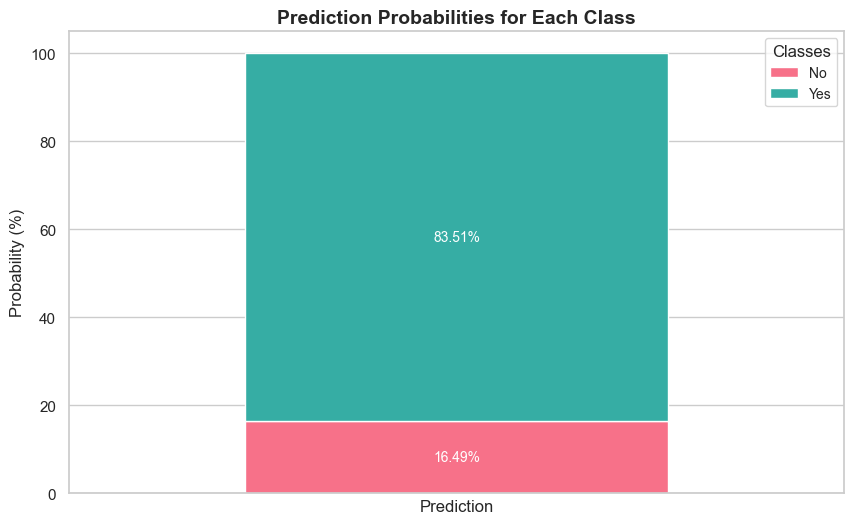

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("24_(SYS)_SU_Received_User_Output_Data.csv", header=None, on_bad_lines='skip')

print(df)

prob_no = float(df[df[0].str.contains("Possibility of No", na=False)][1].values[0].strip('%'))
prob_yes = float(df[df[0].str.contains("Possibility of Yes", na=False)][1].values[0].strip('%'))

probability_df = pd.DataFrame({"No": [prob_no], "Yes": [prob_yes]})

sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Arial"

colors = sns.color_palette("husl", 2)

plt.figure(figsize=(10, 6))
ax = probability_df.plot(kind='bar', stacked=True, color=colors, width=0.6, figsize=(10, 6))

plt.title("Prediction Probabilities for Each Class", fontsize=14, weight='bold')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Probability (%)", fontsize=12)
plt.xticks(ticks=[], labels=[])
plt.legend(title="Classes", loc='upper right', fontsize=10)

for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + height / 2
    ax.annotate(f'{height:.2f}%', (x, y), ha='center', va='center', fontsize=10, color='white')

plt.savefig('Images/24_(SYS)_SU_Probability_of_each_class_.jpeg', transparent=True)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_15788\1453264031.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


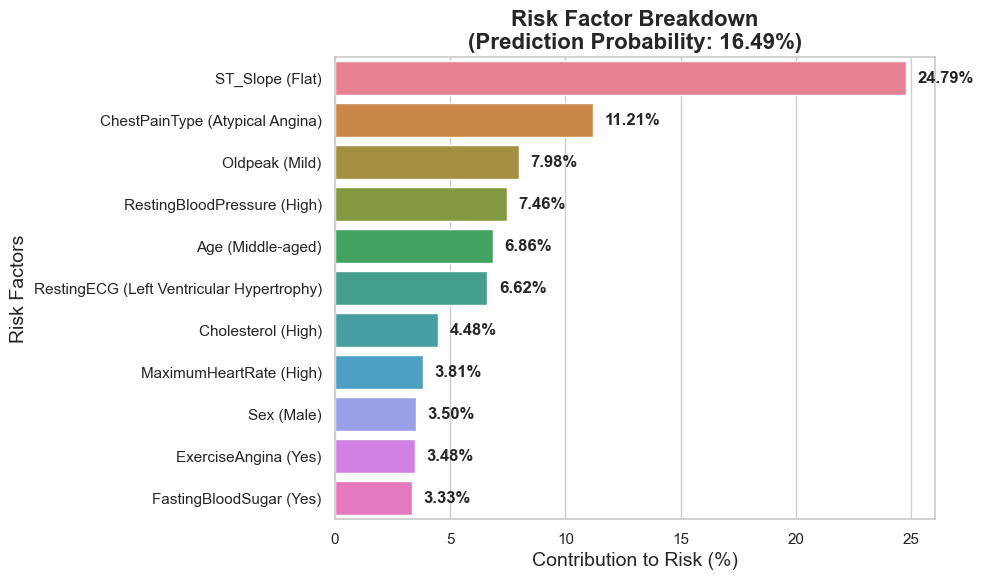

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Arial"

with open("24_(SYS)_SU_Received_User_Output_Data.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

prob_yes = float(lines[2].split(",")[1].strip().strip("%"))  

features_data = [line.strip().split(",") for line in lines[4:]]  

feature_contributions = pd.DataFrame(features_data, columns=["Feature", "Value", "Contribution (%)"])
feature_contributions["Contribution (%)"] = feature_contributions["Contribution (%)"].str.rstrip('%').astype(float)

feature_contributions["Feature_Label"] = feature_contributions["Feature"] + " (" + feature_contributions["Value"] + ")"

feature_contributions = feature_contributions.sort_values(by="Contribution (%)", ascending=False)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(feature_contributions))

sns.barplot(
    y=feature_contributions["Feature_Label"],
    x=feature_contributions["Contribution (%)"],
    palette=colors
)

plt.xlabel("Contribution to Risk (%)", fontsize=14)
plt.ylabel("Risk Factors", fontsize=14)
plt.title(f"Risk Factor Breakdown\n(Prediction Probability: {prob_yes:.2f}%)", fontsize=16, weight='bold')

for index, value in enumerate(feature_contributions["Contribution (%)"]):
    plt.text(value + 0.5, index, f"{value:.2f}%", va='center', fontsize=12, fontweight='bold')

plt.subplots_adjust(left=0.3)  # optional but helpful
plt.savefig('Images/24_(SYS)_SU_Risk_Factor_Breakdown_.jpeg', transparent=True, bbox_inches='tight')
plt.show()
